In [1]:
"""Pandas crosstab explanation."""

'Pandas crosstab explanation.'

# Объяснение кросс-таблицы в pandas

# Введение

Pandas предлагает несколько вариантов группировки и обобщения данных, но такое разнообразие вариантов может быть как благословением, так и проклятием. Все эти подходы являются мощными инструментами анализа данных, но не всегда понятно, использовать ли [`groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html), [`pivot_table`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html) или [`crosstab`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html) для построения сводной таблицы.

Поскольку я [ранее рассматривал `pivot_tables`](https://dfedorov.spb.ru/pandas/%D0%A1%D0%B2%D0%BE%D0%B4%D0%BD%D0%B0%D1%8F%20%D1%82%D0%B0%D0%B1%D0%BB%D0%B8%D1%86%D0%B0%20%D0%B2%20pandas.html), в этой статье будет обсуждаться функция `crosstab`, объяснено ее использование и показано, как ее можно использовать для быстрого суммирования данных.

> оригинал статьи Криса по [ссылке](https://pbpython.com/pandas-crosstab.html)

## Обзор

Функция [`crosstab`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html) создает таблицу кросс-табуляции, которая может показать частоту, с которой появляются определенные группы данных.

В качестве быстрого примера в следующей таблице показано количество двух- или четырехдверных автомобилей, произведенных различными автопроизводителями:

<img src="https://github.com/dm-fedorov/pandas_basic/blob/master/pic/cross_tab.jpg?raw=true" alt="cross_tab" width="250"/>

В таблице видно, что набор данных содержит `32` автомобиля `Toyota`, из которых `18` четырехдверные и `14` двухдверные. Это относительно простая для интерпретации таблица, которая иллюстрирует, почему данный подход может стать мощным способом обобщения больших наборов данных.

Pandas упрощает этот процесс и позволяет настраивать таблицы несколькими способами. В оставшейся части статьи я расскажу, как создавать и настраивать эти таблицы.

Давайте начнем с импорта всех необходимых модулей:

In [2]:
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")

%matplotlib inline

Теперь прочитаем [набор данных об автомобилях](https://archive.ics.uci.edu/ml/datasets/automobile) из репозитория машинного обучения UCI и внесем для ясности некоторые изменения в наименование меток.

> Этот набор данных из автомобильного ежегодника Уорда 1985 года состоит из трех типов записей: (а) спецификация автомобиля с точки зрения различных характеристик, (б) присвоенный ему рейтинг страхового риска, (в) его нормализованные потери при использовании по сравнению с другими автомобилями.

In [3]:
# Определим заголовки:
headers = [
    "symboling",
    "normalized_losses",
    "make",
    "fuel_type",
    "aspiration",
    "num_doors",
    "body_style",
    "drive_wheels",
    "engine_location",
    "wheel_base",
    "length",
    "width",
    "height",
    "curb_weight",
    "engine_type",
    "num_cylinders",
    "engine_size",
    "fuel_system",
    "bore",
    "stroke",
    "compression_ratio",
    "horsepower",
    "peak_rpm",
    "city_mpg",
    "highway_mpg",
    "price",
]

In [4]:
# pylint: disable=line-too-long

# Прочитаем CSV-файл и преобразуем "?" в NaN:
df_raw = pd.read_csv(
    "https://github.com/dm-fedorov/pandas_basic/blob/master/%D0%B1%D1%8B%D1%81%D1%82%D1%80%D0%BE%D0%B5%20%D0%B2%D0%B2%D0%B5%D0%B4%D0%B5%D0%BD%D0%B8%D0%B5%20%D0%B2%20pandas/data/imports-85.data?raw=true",
    header=None,
    names=headers,
    na_values="?",
)
df_raw.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [5]:
# Быстро взглянем на все значения в данных:
df_raw.describe()

,symboling,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
count,205.000000,164.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,201.000000,201.000000,205.000000,203.000000,203.000000,205.000000,205.000000,201.000000
mean,0.834146,122.000000,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329751,3.255423,10.142537,104.256158,5125.369458,25.219512,30.751220,13207.129353
std,1.245307,35.442168,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.273539,0.316717,3.972040,39.714369,479.334560,6.542142,6.886443,7947.066342
min,-2.000000,65.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,0.000000,94.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7775.000000
50%,1.000000,115.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,2.000000,150.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.590000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16500.000000
max,3.000000,256.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


In [6]:
# Определим список моделей, которые хотим рассмотреть:
models = [
    "toyota",
    "nissan",
    "mazda",
    "honda",
    "mitsubishi",
    "subaru",
    "volkswagen",
    "volvo",
]

In [7]:
# Создадим копию данных только с 8 ведущими производителями:
df = df_raw[df_raw.make.isin(models)].copy()
df.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
30,2,137.0,honda,gas,std,two,hatchback,fwd,front,86.6,...,92,1bbl,2.91,3.41,9.6,58.0,4800.0,49,54,6479.0
31,2,137.0,honda,gas,std,two,hatchback,fwd,front,86.6,...,92,1bbl,2.91,3.41,9.2,76.0,6000.0,31,38,6855.0
32,1,101.0,honda,gas,std,two,hatchback,fwd,front,93.7,...,79,1bbl,2.91,3.07,10.1,60.0,5500.0,38,42,5399.0
33,1,101.0,honda,gas,std,two,hatchback,fwd,front,93.7,...,92,1bbl,2.91,3.41,9.2,76.0,6000.0,30,34,6529.0
34,1,101.0,honda,gas,std,two,hatchback,fwd,front,93.7,...,92,1bbl,2.91,3.41,9.2,76.0,6000.0,30,34,7129.0


В этом примере я хотел сократить таблицу, поэтому включил только 8 моделей, перечисленных выше.

В качестве первого примера давайте воспользуемся `crosstab`, чтобы посмотреть, сколько различных стилей кузова изготовили эти автопроизводители в 1985 году (год, который содержится в этом наборе данных):

In [8]:
pd.crosstab(df.make, df.body_style)

body_style,convertible,hardtop,hatchback,sedan,wagon
make,,,,,
honda,0,0,7,5,1
mazda,0,0,10,7,0
mitsubishi,0,0,9,4,0
nissan,0,1,5,9,3
subaru,0,0,3,5,4
toyota,1,3,14,10,4
volkswagen,1,0,1,9,1
volvo,0,0,0,8,3


Функция `crosstab` может работать с массивами `numpy`, т.е. с `series` или столбцами во фрейме данных.

В этом примере я передаю `df.make` для индекса кросс-таблицы и `df.body_style` для столбцов кросс-таблицы. Pandas подсчитывает количество вхождений каждой комбинации. Например, в этом наборе данных `Volvo` производит 8 седанов и 3 универсала.

Прежде чем мы пойдем дальше, более опытные читатели могут задаться вопросом, почему мы используем именно `crosstab`. Я кратко коснусь этого, показав два альтернативных подхода.

Во-первых, мы можем использовать `groupby`, а затем `unstack`, чтобы получить те же результаты:

In [9]:
df.groupby(["make", "body_style"])["body_style"].count().unstack().fillna(0)

body_style,convertible,hardtop,hatchback,sedan,wagon
make,,,,,
honda,0.0,0.0,7.0,5.0,1.0
mazda,0.0,0.0,10.0,7.0,0.0
mitsubishi,0.0,0.0,9.0,4.0,0.0
nissan,0.0,1.0,5.0,9.0,3.0
subaru,0.0,0.0,3.0,5.0,4.0
toyota,1.0,3.0,14.0,10.0,4.0
volkswagen,1.0,0.0,1.0,9.0,1.0
volvo,0.0,0.0,0.0,8.0,3.0


Вывод для этого примера очень похож на кросс-таблицу, но потребовалось несколько дополнительных шагов, чтобы его правильно отформатировать.

Также можно сделать что-то подобное с помощью `pivot_table`:

In [10]:
df.pivot_table(
    index="make", columns="body_style", aggfunc={"body_style": len}, fill_value=0
)

body_style                              
body_style convertible hardtop hatchback sedan wagon
make                                                
honda                0       0         7     5     1
mazda                0       0        10     7     0
mitsubishi           0       0         9     4     0
nissan               0       1         5     9     3
subaru               0       0         3     5     4
toyota               1       3        14    10     4
volkswagen           1       0         1     9     1
volvo                0       0         0     8     3

Обязательно прочтите мою [статью о pivot_tables](https://dfedorov.spb.ru/pandas/%D0%A1%D0%B2%D0%BE%D0%B4%D0%BD%D0%B0%D1%8F%20%D1%82%D0%B0%D0%B1%D0%BB%D0%B8%D1%86%D0%B0%20%D0%B2%20pandas.html), если хотите понять, как это работает.

По-прежнему остается вопрос, зачем вообще использовать функцию `crosstab`?

Короткий ответ заключается в том, что он предоставляет несколько удобных функций для упрощения форматирования и обобщения данных.

Более длинный ответ: бывает сложно запомнить все шаги для самостоятельного выполнения.

> По моему опыту, важно знать о вариантах и использовать тот, который наиболее естественным образом вытекает из анализа.

У меня был опыт, когда я пытался написать решение на основе `pivot_table`, а затем быстро получил то, что хотел, используя `crosstab`.

Самое замечательное в pandas то, что после того, как данные помещены во фрейм, все манипуляции представляют собой 1 строку кода, поэтому вы можете экспериментировать.

## Углубляемся в кросс-таблицу

Одна из распространенных потребностей в кросс-таблице - это включение промежуточных итогов.

Мы можем добавить их с помощью ключевого слова `margins`:

In [11]:
pd.crosstab(df.make, df.num_doors, margins=True, margins_name="Total")

num_doors,four,two,Total
make,,,
honda,5,8,13
mazda,7,9,16
mitsubishi,4,9,13
nissan,9,9,18
subaru,9,3,12
toyota,18,14,32
volkswagen,8,4,12
volvo,11,0,11
Total,71,56,127


Ключевое слово `margins` указало pandas добавлять `Total` (итог) для каждой строки, а также итог внизу.

Я также передал значение в `margins_name` при вызове функции, потому что хотел обозначить результаты `Total` вместо значения по умолчанию `All`.

Во всех этих примерах подсчитывались отдельные случаи комбинаций данных.

`crosstab` позволяет указывать значения для агрегирования. Чтобы проиллюстрировать это, мы можем рассчитать среднюю снаряженную массу автомобилей по типу кузова и производителю:

In [12]:
pd.crosstab(df.make, df.body_style, values=df.curb_weight, aggfunc="mean").round(0)

body_style,convertible,hardtop,hatchback,sedan,wagon
make,,,,,
honda,NaN,NaN,1970.0,2289.0,2024.0
mazda,NaN,NaN,2254.0,2361.0,NaN
mitsubishi,NaN,NaN,2377.0,2394.0,NaN
nissan,NaN,2008.0,2740.0,2238.0,2452.0
subaru,NaN,NaN,2137.0,2314.0,2454.0
toyota,2975.0,2585.0,2370.0,2338.0,2708.0
volkswagen,2254.0,NaN,2221.0,2342.0,2563.0
volvo,NaN,NaN,NaN,3023.0,3078.0


Используя `aggfunc='mean'` и `values=df.curb_weight`, мы говорим pandas применить функцию `mean` к весу снаряжения для всех комбинаций данных. Под капотом pandas группирует все значения вместе по `make` и `body_style`, а затем вычисляет среднее значение. В тех областях, где нет машины с такими значениями, отображается `NaN`. В этом примере я также округляю результаты.

Мы видели, как подсчитывать значения и определять средние значения. Однако есть еще один распространенный случай суммирования данных, когда мы хотим понять, сколько процентов от общего числа составляет каждая комбинация. Это можно сделать с помощью параметра `normalize`:

In [13]:
pd.crosstab(df.make, df.body_style, normalize=True)

body_style,convertible,hardtop,hatchback,sedan,wagon
make,,,,,
honda,0.000000,0.000000,0.054688,0.039062,0.007812
mazda,0.000000,0.000000,0.078125,0.054688,0.000000
mitsubishi,0.000000,0.000000,0.070312,0.031250,0.000000
nissan,0.000000,0.007812,0.039062,0.070312,0.023438
subaru,0.000000,0.000000,0.023438,0.039062,0.031250
toyota,0.007812,0.023438,0.109375,0.078125,0.031250
volkswagen,0.007812,0.000000,0.007812,0.070312,0.007812
volvo,0.000000,0.000000,0.000000,0.062500,0.023438


Эта таблица показывает нам, что `2.3%` от общей численности населения составляют хардтопы `Toyota`, а `6.25%` - седаны `Volvo`.

Параметр `normalize` еще умнее, т.к. он позволяет выполнять сводку отдельно для столбцов или строк.

Например, если мы хотим увидеть, как стили корпуса распределяются по маркам:

In [14]:
pd.crosstab(df.make, df.body_style, normalize="columns")

body_style,convertible,hardtop,hatchback,sedan,wagon
make,,,,,
honda,0.0,0.00,0.142857,0.087719,0.0625
mazda,0.0,0.00,0.204082,0.122807,0.0000
mitsubishi,0.0,0.00,0.183673,0.070175,0.0000
nissan,0.0,0.25,0.102041,0.157895,0.1875
subaru,0.0,0.00,0.061224,0.087719,0.2500
toyota,0.5,0.75,0.285714,0.175439,0.2500
volkswagen,0.5,0.00,0.020408,0.157895,0.0625
volvo,0.0,0.00,0.000000,0.140351,0.1875


Взглянув только на колонку кабриолетов, можно увидеть, что `50%` автомобилей с откидным верхом производится `Toyota`, а остальные `50%` - `Volkswagen`.

Мы можем сделать то же самое по строкам:

pd.crosstab(df.make,
            df.body_style,
            normalize='index')

Это представление данных показывает, что из автомобилей `Mitsubishi` в этом наборе данных `69.23%` - это хэтчбеки, а оставшаяся часть (`30.77%`) - седаны.

Я надеюсь, вы согласитесь с тем, что эти приемы могут быть полезны во многих видах анализа.

## Группировка

Одна из наиболее полезных особенностей кросс-таблицы заключается в том, что вы можете передавать несколько столбцов фрейма данных, а pandas выполняет всю группировку за вас.

Например, если мы хотим увидеть, как данные распределяются по переднему приводу (`fwd`) и заднему приводу (`rwd`), мы можем включить столбец `drive_wheels`, включив его в список допустимых столбцов во втором аргументе `crosstab`:

In [15]:
pd.crosstab(df.make, [df.body_style, df.drive_wheels])

body_style   convertible     hardtop     hatchback         sedan          \
drive_wheels         fwd rwd     fwd rwd       4wd fwd rwd   4wd fwd rwd   
make                                                                       
honda                  0   0       0   0         0   7   0     0   5   0   
mazda                  0   0       0   0         0   6   4     0   5   2   
mitsubishi             0   0       0   0         0   9   0     0   4   0   
nissan                 0   0       1   0         0   2   3     0   9   0   
subaru                 0   0       0   0         1   2   0     2   3   0   
toyota                 0   1       0   3         0   8   6     0   7   3   
volkswagen             1   0       0   0         0   1   0     0   9   0   
volvo                  0   0       0   0         0   0   0     0   0   8   

body_style   wagon          
drive_wheels   4wd fwd rwd  
make                        
honda            0   1   0  
mazda            0   0   0  
mitsubishi       0   0   0  
nissan           0   3   0  
subaru           2   2   0  
toyota           2   1   1  
volkswagen       0   1   0  
volvo            0   0   3

То же самое можно сделать и с индексом:

In [16]:
pd.crosstab(
    [df.make, df.num_doors],
    [df.body_style, df.drive_wheels],
    rownames=["Auto Manufacturer", "Doors"],
    colnames=["Body Style", "Drive Type"],
    dropna=False,
)

Body Style              convertible         hardtop         hatchback          \
Drive Type                      4wd fwd rwd     4wd fwd rwd       4wd fwd rwd   
Auto Manufacturer Doors                                                         
honda             four            0   0   0       0   0   0         0   0   0   
                  two             0   0   0       0   0   0         0   7   0   
                  NaN             0   0   0       0   0   0         0   0   0   
mazda             four            0   0   0       0   0   0         0   1   0   
                  two             0   0   0       0   0   0         0   5   4   
                  NaN             0   0   0       0   0   0         0   0   0   
mitsubishi        four            0   0   0       0   0   0         0   0   0   
                  two             0   0   0       0   0   0         0   9   0   
                  NaN             0   0   0       0   0   0         0   0   0   
nissan            four            0   0   0       0   0   0         0   1   0   
                  two             0   0   0       0   1   0         0   1   3   
                  NaN             0   0   0       0   0   0         0   0   0   
subaru            four            0   0   0       0   0   0         0   0   0   
                  two             0   0   0       0   0   0         1   2   0   
                  NaN             0   0   0       0   0   0         0   0   0   
toyota            four            0   0   0       0   0   0         0   6   0   
                  two             0   0   1       0   0   3         0   2   6   
                  NaN             0   0   0       0   0   0         0   0   0   
volkswagen        four            0   0   0       0   0   0         0   0   0   
                  two             0   1   0       0   0   0         0   1   0   
                  NaN             0   0   0       0   0   0         0   0   0   
volvo             four            0   0   0       0   0   0         0   0   0   
                  two             0   0   0       0   0   0         0   0   0   
                  NaN             0   0   0       0   0   0         0   0   0   

Body Style              sedan         wagon          
Drive Type                4wd fwd rwd   4wd fwd rwd  
Auto Manufacturer Doors                              
honda             four      0   4   0     0   1   0  
                  two       0   1   0     0   0   0  
                  NaN       0   0   0     0   0   0  
mazda             four      0   4   2     0   0   0  
                  two       0   0   0     0   0   0  
                  NaN       0   1   0     0   0   0  
mitsubishi        four      0   4   0     0   0   0  
                  two       0   0   0     0   0   0  
                  NaN       0   0   0     0   0   0  
nissan            four      0   5   0     0   3   0  
                  two       0   4   0     0   0   0  
                  NaN       0   0   0     0   0   0  
subaru            four      2   3   0     2   2   0  
                  two       0   0   0     0   0   0  
                  NaN       0   0   0     0   0   0  
toyota            four      0   7   1     2   1   1  
                  two       0   0   2     0   0   0  
                  NaN       0   0   0     0   0   0  
volkswagen        four      0   7   0     0   1   0  
                  two       0   2   0     0   0   0  
                  NaN       0   0   0     0   0   0  
volvo             four      0   0   8     0   0   3  
                  two       0   0   0     0   0   0  
                  NaN       0   0   0     0   0   0

Я ввел пару дополнительных параметров для управления способом отображения вывода.

Во-первых, я задал определенные `rownames` и `colnames`, которые хочу включить в вывод. Это чисто для целей отображения, но может быть полезно, если имена столбцов во фрейме данных не конкретны.

Затем я использовал `dropna=False` в конце вызова функции. Причина, по которой я это включил, состоит в том, что я хотел убедиться, что включены все строки и столбцы, даже если в них все нули. Если бы я не включил его, то последний `Volvo`, двухдверный ряд, был бы исключен из таблицы.

Я хочу сделать последнее замечание по поводу этой таблицы. Она содержит много информации и может быть слишком трудной для интерпретации. Вот тут-то и приходит на помощь искусство науки о данных (или любого анализа), и вам нужно определить лучший способ представления данных.

Приведу еще несколько примеров с различными параметрами:

In [17]:
# Вы также можете использовать функции агрегирования при группировке:
pd.crosstab(
    df.make, [df.body_style, df.drive_wheels], values=df.curb_weight, aggfunc="mean"
).fillna("-")

body_style   convertible         hardtop         hatchback               \
drive_wheels         fwd     rwd     fwd     rwd       4wd          fwd   
make                                                                      
honda                  -       -       -       -         -       1970.0   
mazda                  -       -       -       -         -  2148.333333   
mitsubishi             -       -       -       -         -  2376.555556   
nissan                 -       -  2008.0       -         -       2176.0   
subaru                 -       -       -       -    2240.0       2085.0   
toyota                 -  2975.0       -  2585.0         -      2177.25   
volkswagen        2254.0       -       -       -         -       2221.0   
volvo                  -       -       -       -         -            -   

body_style                  sedan                             wagon  \
drive_wheels          rwd     4wd          fwd          rwd     4wd   
make                                                                  
honda                   -       -       2288.8            -       -   
mazda             2411.25       -       2231.6       2685.0       -   
mitsubishi              -       -       2394.0            -       -   
nissan        3116.333333       -  2237.888889            -       -   
subaru                  -  2447.5       2225.0            -  2535.0   
toyota        2626.833333       -  2258.571429  2521.666667  2700.0   
volkswagen              -       -  2342.222222            -       -   
volvo                   -       -            -       3023.0       -   

body_style                              
drive_wheels          fwd          rwd  
make                                    
honda              2024.0            -  
mazda                   -            -  
mitsubishi              -            -  
nissan        2452.333333            -  
subaru             2372.5            -  
toyota             2280.0       3151.0  
volkswagen         2563.0            -  
volvo                   -  3077.666667

In [18]:
# Вы можете использовать промежуточные итоги (margins) при группировке:
pd.crosstab(
    df.make,
    [df.body_style, df.drive_wheels],
    values=df.curb_weight,
    aggfunc="mean",
    margins=True,
    margins_name="Average",
).fillna("-").round(0)

body_style   convertible         hardtop         hatchback               \
drive_wheels         fwd     rwd     fwd     rwd       4wd          fwd   
make                                                                      
honda                  -       -       -       -         -       1970.0   
mazda                  -       -       -       -         -  2148.333333   
mitsubishi             -       -       -       -         -  2376.555556   
nissan                 -       -  2008.0       -         -       2176.0   
subaru                 -       -       -       -    2240.0       2085.0   
toyota                 -  2975.0       -  2585.0         -      2177.25   
volkswagen        2254.0       -       -       -         -       2221.0   
volvo                  -       -       -       -         -            -   
Average           2254.0  2975.0  2008.0  2585.0    2240.0       2178.0   

body_style                  sedan                             wagon  \
drive_wheels          rwd     4wd          fwd          rwd     4wd   
make                                                                  
honda                   -       -       2288.8            -       -   
mazda             2411.25       -       2231.6       2685.0       -   
mitsubishi              -       -       2394.0            -       -   
nissan        3116.333333       -  2237.888889            -       -   
subaru                  -  2447.5       2225.0            -  2535.0   
toyota        2626.833333       -  2258.571429  2521.666667  2700.0   
volkswagen              -       -  2342.222222            -       -   
volvo                   -       -            -       3023.0       -   
Average       2673.461538  2447.5  2282.952381  2855.307692  2617.5   

body_style                             Average  
drive_wheels          fwd          rwd          
make                                            
honda              2024.0            -  2097.0  
mazda                   -            -  2298.0  
mitsubishi              -            -  2382.0  
nissan        2452.333333            -  2400.0  
subaru             2372.5            -  2316.0  
toyota             2280.0       3151.0  2441.0  
volkswagen         2563.0            -  2343.0  
volvo                   -  3077.666667  3038.0  
Average          2371.125       3096.0  2406.0

Перейдем к заключительной части статьи.

## Визуализация

В последнем примере я соберу все воедино, показав, как выходные данные кросс-таблицы могут быть переданы на тепловую карту `Seaborn`, чтобы визуально обобщить данные.

В одной из наших кросс-таблиц мы получили 240 значений. Это слишком много, чтобы быстро анализировать, но если мы используем тепловую карту, то сможем легко интерпретировать данные.

К счастью, `Seaborn` позволяет взять результат кросс-таблицы и визуализировать его:

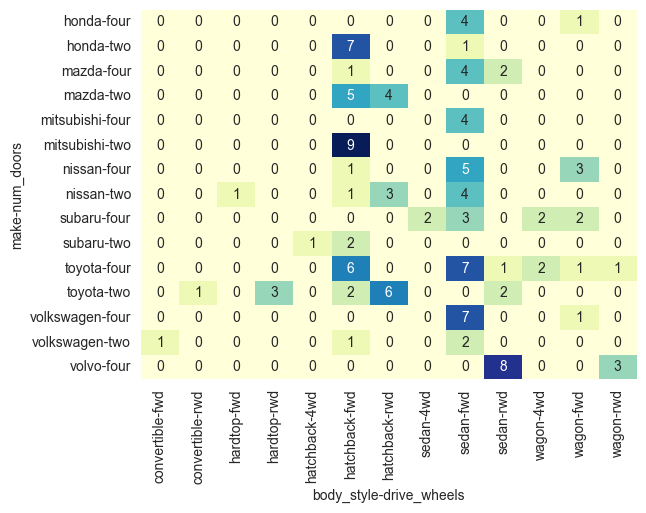

In [19]:
sns.heatmap(
    pd.crosstab([df.make, df.num_doors], [df.body_style, df.drive_wheels]),
    cmap="YlGnBu",
    annot=True,
    cbar=False,
);

Одним из действительно полезных аспектов этого подхода является то, что `Seaborn` сворачивает сгруппированные имена столбцов и строк, чтобы их было легче читать.

## Шпаргалка

Чтобы собрать все воедино, вот памятка, показывающая, как использовать все компоненты функции `crosstab`.

Вы можете скачать PDF-версию по [ссылке](https://dfedorov.spb.ru/pandas/cheatsheet/crosstab_cheatsheet.pdf).

![](https://github.com/dm-fedorov/pandas_basic/blob/master/pic/crosstab_cheatsheet.png?raw=true)

# Заключение

Функция `crosstab` - полезный инструмент для обобщения данных. Функциональность пересекается с некоторыми другими инструментами pandas, но занимает полезное место в вашем наборе инструментов для анализа данных. Прочитав эту статью, вы сможете использовать ее в своем собственном анализе данных.